Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


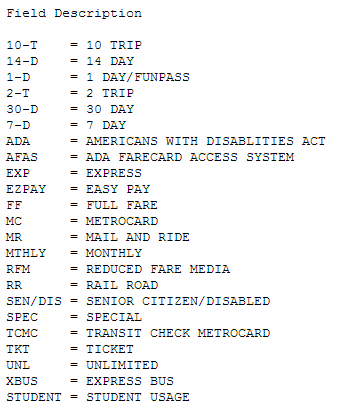

In [1]:
from __future__ import print_function, division
import pylab as pl
import matplotlib as plt
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

import urllib

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

In [2]:
urllib.request.urlretrieve('https://github.com/fedhere/PUI2018_fb55/raw/master/HW11_fb55/MTA_Fare.npy','MTA_Fare.npy')

('MTA_Fare.npy', <http.client.HTTPMessage at 0x7fa7aa5af160>)

In [3]:
!mv MTA_Fare.npy "/nfshome/jl9489/PUI2018/HW11_jl9489"

mv: 'MTA_Fare.npy' and '/nfshome/jl9489/PUI2018/HW11_jl9489/MTA_Fare.npy' are the same file


In [4]:
mta_fare = np.load('MTA_Fare.npy')

In [5]:
mta_fare.size

2677200

## read in data as instructed above

In [6]:
print ("MTA array shape:", mta_fare.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta_fare,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


In [7]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


In [8]:
mta_weeks = pd.date_range(start='5/19/2010', periods=194, freq='W')

In [9]:
mta_weeks

DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')

In [10]:
mta_fare = mta_fare.astype(float)

In [11]:
mta_fare[mta_fare == -1.00000000e+00] = 'nan'

In [12]:
mta_fare

array([[[  5.69610000e+04,   6.47030000e+04,   6.80020000e+04, ...,
           3.65270000e+04,   3.39290000e+04,   3.68240000e+04],
        [  1.73200000e+03,   2.08300000e+03,   2.10700000e+03, ...,
           1.26400000e+03,   1.17200000e+03,   1.23800000e+03],
        [  2.03000000e+02,   2.76000000e+02,   2.45000000e+02, ...,
           1.86000000e+02,   1.67000000e+02,   1.67000000e+02],
        ..., 
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [             nan,              nan,              nan, ...,
           1.12100000e+03,   1.37700000e+03,   7.12000000e+02]],

       [[  1.62100000e+04,   2.01790000e+04,   2.17690000e+04, ...,
                      nan,              nan,              nan],
        [  5.03000000e+02,   6.47000000e+02,   6.65000000e+0

In [13]:
mta_fare = np.nan_to_num(mta_fare)

In [14]:
mta_fare.dtype

dtype('float64')

In [15]:
mta_fare.shape

(600, 23, 194)

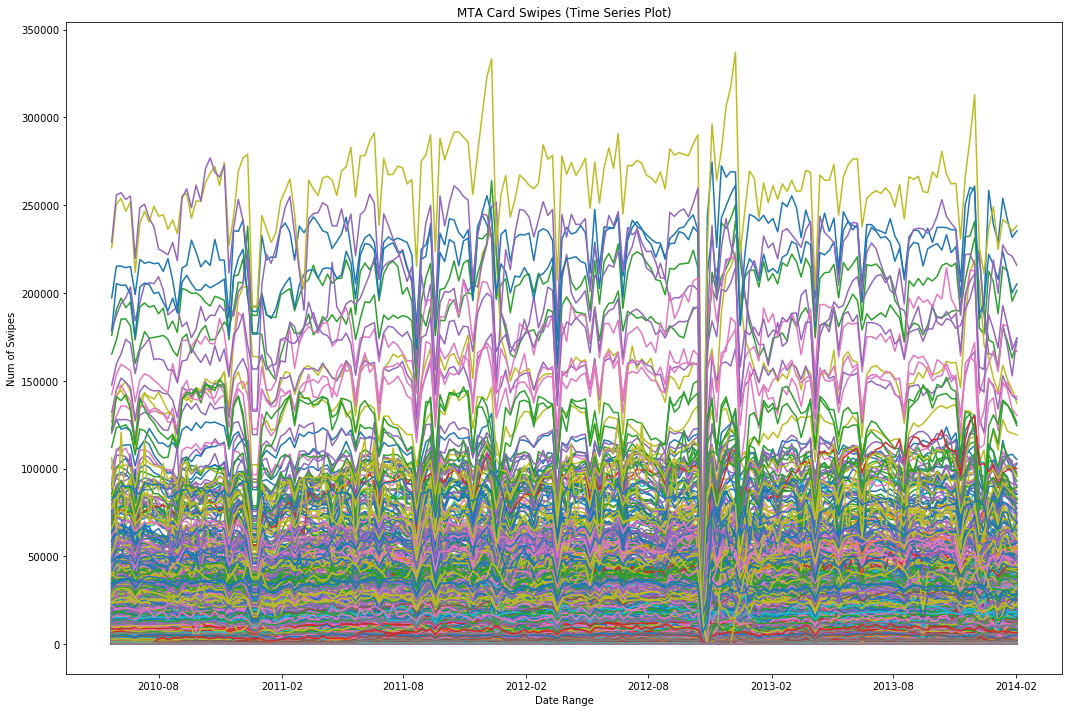

In [16]:
fig, ax = plt.subplots(figsize=(15,10))


for i in list(range(0,599)):
    for j in list(range(0,22)):
        ax.plot(mta_weeks,mta_fare[i][j])
        

plt.xlabel('Date Range')
plt.ylabel('Num of Swipes')
plt.title('MTA Card Swipes (Time Series Plot)')
plt.tight_layout()

Fig 1: The above plot shows the number of swipes on MTA buses in the given dataset.  It creates a very messy plot, which makes it difficult to find any clear patterns.

In [17]:
mta_fare_log = np.log10(mta_fare)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


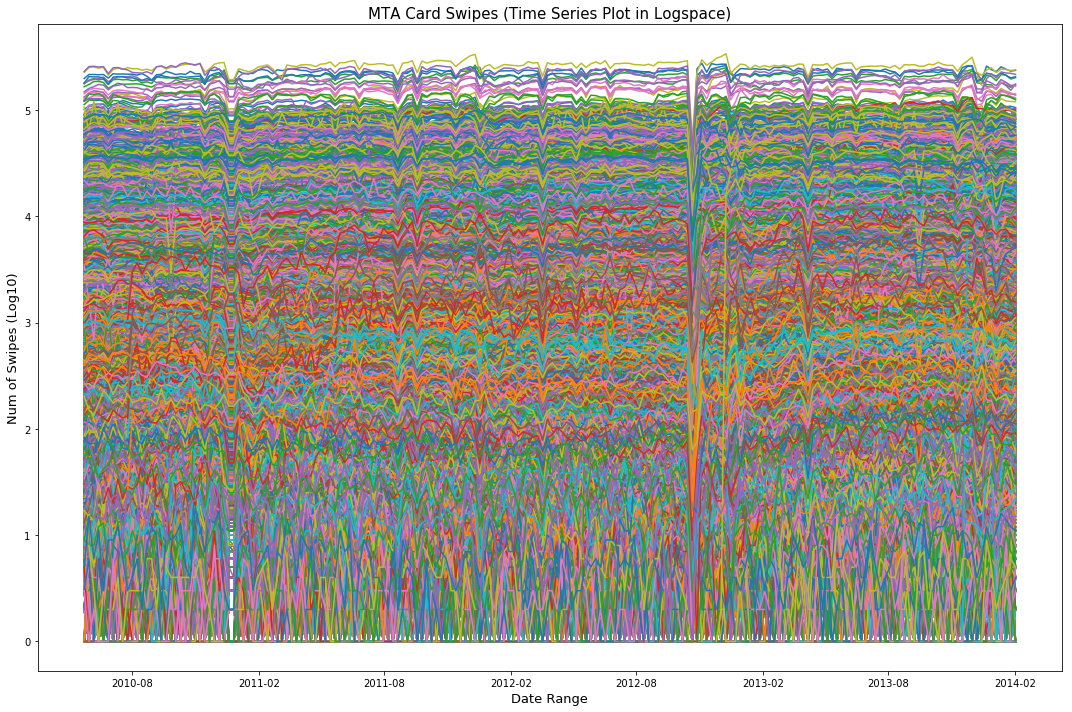

In [19]:
fig, ax = plt.subplots(figsize=(15,10))


for i in list(range(0,599)):
    for j in list(range(0,22)):
        ax.plot(mta_weeks,mta_fare_log[i][j])
        

plt.xlabel('Date Range',fontsize=13)
plt.ylabel('Num of Swipes (Log10)',fontsize=13)
plt.title('MTA Card Swipes (Time Series Plot in Logspace)',fontsize=15)
plt.tight_layout()

Fig 2: The above plot shows the total number of MTA card swipes over the different buses, plotted over a logarithmic scale.  While it is difficult to discern patterns, there is a clear dip in the number of swipes.  This most likely corresponds to the direct aftermath of Hurricane Sandy (10-22-2012 to 11-2-2012), which affected public transportation throughout NYC.

## 1: event detection

In [20]:
def changeFinder(data):

    n = len(data)
    datamean = np.nanmean(data)
    datasqmean = np.nanmean(data**2)
    fac = datasqmean - datamean**2
    
    datacsum = np.nancumsum(data)
    datasum = datacsum[-1]

    ppoc = np.zeros(n) #container for point of change relative prob

    #online (iterative) search for point of change
    for m in range(n-1):
        pos = m + 1
        relativePosition = (pos) * (n - pos)
 
        Q = datacsum[m] - (datasum - datacsum[m]) #cumsum up to m - cumsum after
        
        U = -(datamean * (n - 2 * pos) + Q)**2 / (4.0 * relativePosition) + fac
       
        ppoc[m+1] = (-(n * 0.5 - 1) * np.log(n * U * 0.5) - 
                 0.5 * np.log(relativePosition))

    ppoc[0] = min(ppoc[1:])
    changePoint = np.argmax(ppoc)
    
    return {'pChange': ppoc, 
            'pointOfChange': changePoint + 1,
            'meanBefore': (data[:changePoint+1]).mean(), 
            'meanAfter': (data[(changePoint+1):]).mean()}

In [21]:
pochange = changeFinder(mta_fare[0][0])
pochange['pointOfChange']

127

In [22]:
# Create an array of total swipe counts by week

mta_fare2 = np.nansum(mta_fare, axis=0)
mta_fare3 = np.nansum(mta_fare2, axis=0)

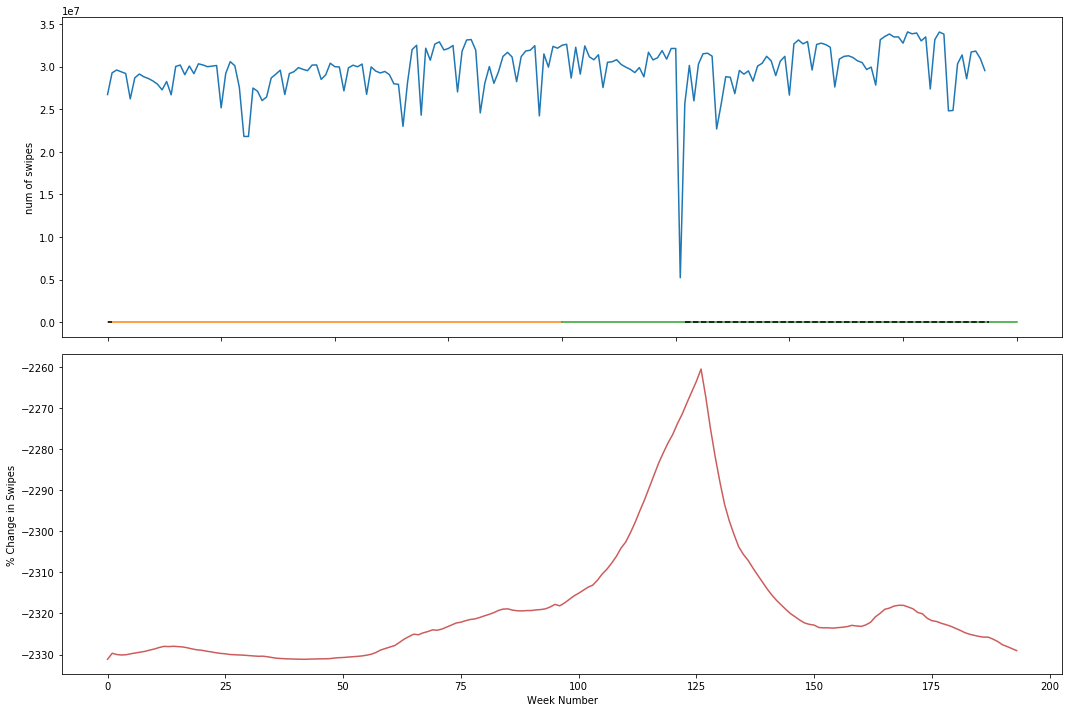

In [23]:
fig = pl.figure(figsize=(15,10))
ax1 = pl.subplot(211)
ax1.plot(range(len(mta_fare3)), mta_fare3)
ax1.plot([0,100], [0,0], '-')
ax1.plot([100,200],[3,3], '-')
ax1.set_xticklabels(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel("num of swipes")

ax2 = pl.subplot(212)
ax2.plot(range(len(mta_fare3)), 
        pochange['pChange'], color="IndianRed")
ax1.plot(0,[pochange['pointOfChange']], 
         [pochange['meanBefore'], pochange['meanBefore']], 'k--')
ax1.plot([pochange['pointOfChange'],len(mta_fare3)], 
         [pochange['meanAfter'], pochange['meanAfter']], 'k--')
ax2.set_ylabel("% Change in Swipes")
ax2.set_xlabel("Week Number")

pl.tight_layout()

Fig 3: The above plot shows the total number of swipes over the time series in the dataset.  The below plot shows the same dataset and time series, but instead indicates the percent change in the swipe count.  As can be seen, the total number and percent change experience the biggest jump at the same point.  It is around Week Number 127, which has been deduced algorithmically in previous block of code.

In [24]:
# Determine the statistics for swipe count

print ("mean swipes by day {:.2f}".format(mta_fare3.mean()))
print ("stdev swipes by day {:.2f}".format(mta_fare3.std()))
thresholds = [mta_fare3.mean() + 3 * mta_fare3.std(), 
              mta_fare3.mean() - 3 * mta_fare3.std()]
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))

mean swipes by day 29781349.87
stdev swipes by day 2983960.42
3-sigma thresholds 38733231.14 20829468.61


In [25]:
# Find value below the 3-sigma threshold

mta_fare3 < thresholds[1]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False,

In [26]:
# Convert to dataframe for easier plot

mtatest = pd.DataFrame(data=mta_fare3)

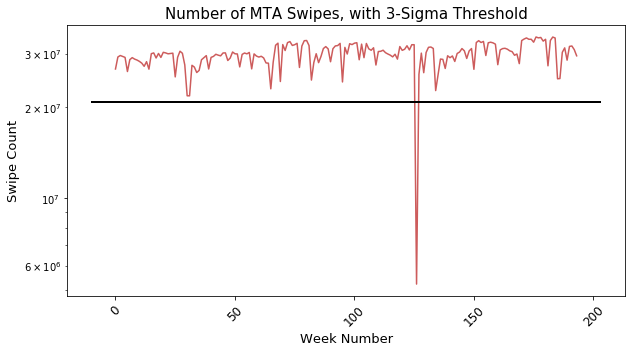

In [27]:
# Plot the threshold to find outliers

ax = mtatest.plot(logy=True, figsize=(10,5), style="-", ms=20, color="IndianRed")
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]], color="Black", lw=2)
ax.legend().remove()
pl.xticks(rotation=45, fontsize=12)
pl.xlabel('Week Number',fontsize=13)
pl.ylabel('Swipe Count',fontsize=13)
pl.title('Number of MTA Swipes, with 3-Sigma Threshold',fontsize=15)

Fig 4: Similar to the top plot of Figure 3.  The major addition is a horizontal line indicating the swipe count at 3 standard deviations from the mean.  This is to further reinforce that Week Number 127 is an extreme outlier.

In [28]:
# Collapse dataset along first dimension, to isolate card type and week number

mta_ridetype = np.nanmean(mta_fare, axis=0)
mta_ridetype.shape

(23, 194)

In [29]:
mta_ridetype

array([[  1.91576917e+04,   2.08780983e+04,   2.12777117e+04, ...,
          2.19826833e+04,   2.08345933e+04,   2.07665783e+04],
       [  8.84206667e+02,   9.72555000e+02,   9.76990000e+02, ...,
          1.15855667e+03,   1.11704667e+03,   1.13249500e+03],
       [  7.96683333e+01,   8.58100000e+01,   8.60600000e+01, ...,
          9.79516667e+01,   9.42083333e+01,   9.19866667e+01],
       ..., 
       [  1.02133333e+01,   1.02000000e+01,   1.08166667e+01, ...,
          8.99666667e+00,   9.59833333e+00,   1.03066667e+01],
       [  5.96666667e-01,   7.90000000e-01,   7.75000000e-01, ...,
          1.43666667e+00,   1.35000000e+00,   1.36666667e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.88787167e+03,   2.29900500e+03,   8.91696667e+02]])

In [30]:
mta_ridetype_df = pd.DataFrame(mta_ridetype, index= ridetype).T
mta_ridetype_df_rolling = mta_ridetype_df.rolling(10, min_periods=5).mean()
mta_ridetype_df_rolling.head()

10t      14d      1d          2t        30d           7d  \
0       NaN      NaN     NaN         NaN        NaN          NaN   
1       NaN      NaN     NaN         NaN        NaN          NaN   
2       NaN      NaN     NaN         NaN        NaN          NaN   
3       NaN      NaN     NaN         NaN        NaN          NaN   
4  20750.49  937.237  84.713  325.573333  80.264667  6556.826667   

            ada    afas         exp       ez  ...        month       rfm  \
0           NaN     NaN         NaN      NaN  ...          NaN       NaN   
1           NaN     NaN         NaN      NaN  ...          NaN       NaN   
2           NaN     NaN         NaN      NaN  ...          NaN       NaN   
3           NaN     NaN         NaN      NaN  ...          NaN       NaN   
4  15419.650667  18.641  519.757667  958.436  ...   237.200667  1456.808   

           rr     sen      spec        tcmc          t   umlim      xbus  stud  
0         NaN     NaN       NaN         NaN        NaN     NaN       NaN   NaN  
1         NaN     NaN       NaN         NaN        NaN     NaN       NaN   NaN  
2         NaN     NaN       NaN         NaN        NaN     NaN       NaN   NaN  
3         NaN     NaN       NaN         NaN        NaN     NaN       NaN   NaN  
4  111.022667  52.503  0.058667  203.471333  35.363333  10.547  0.744333   0.0  

[5 rows x 23 columns]

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


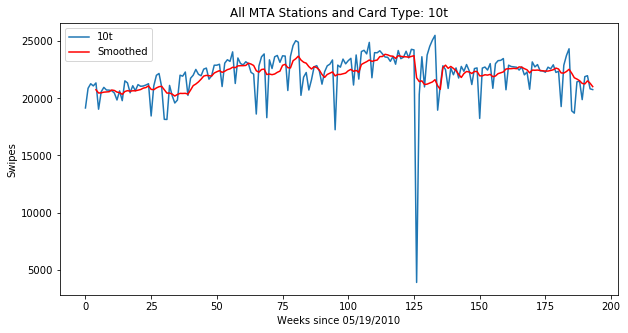

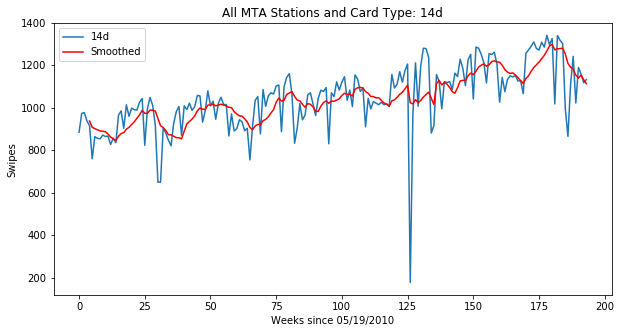

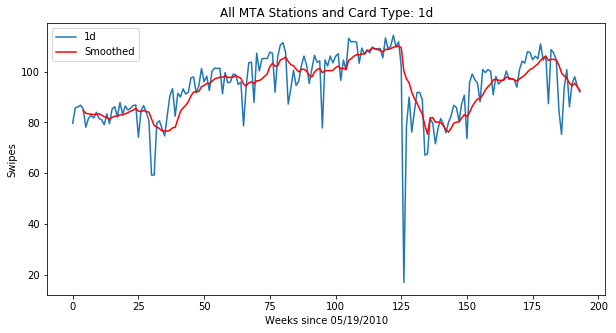

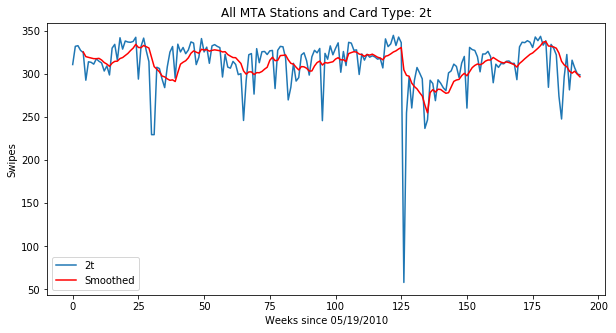

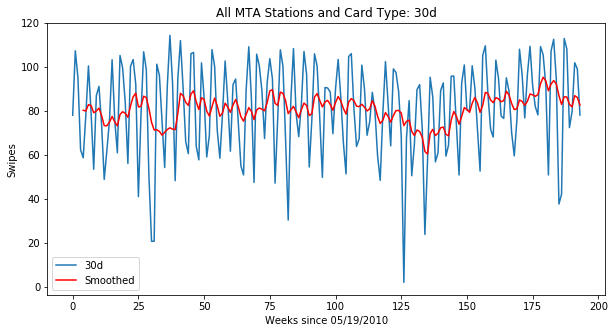

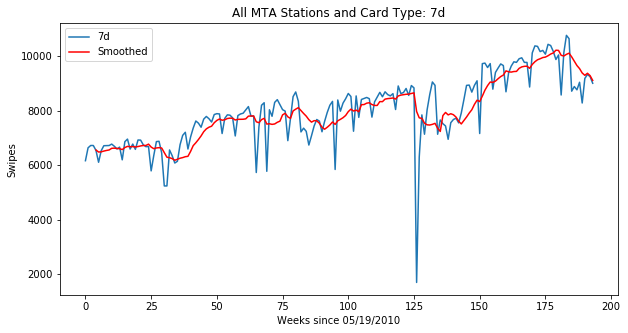

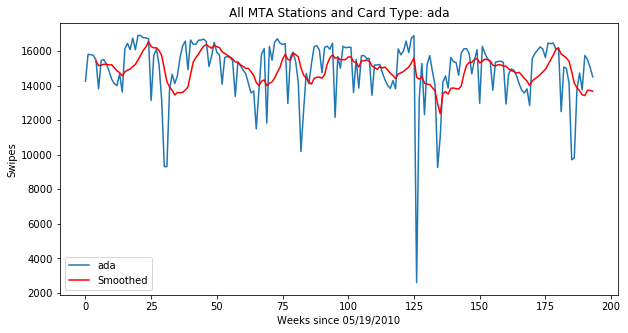

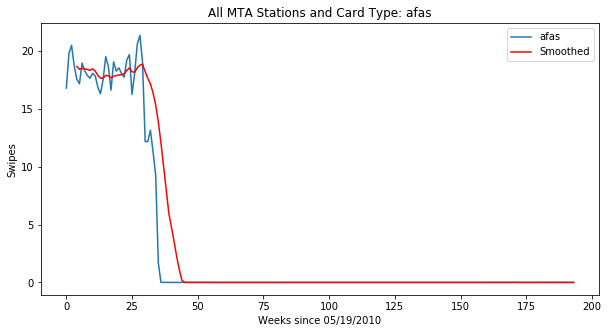

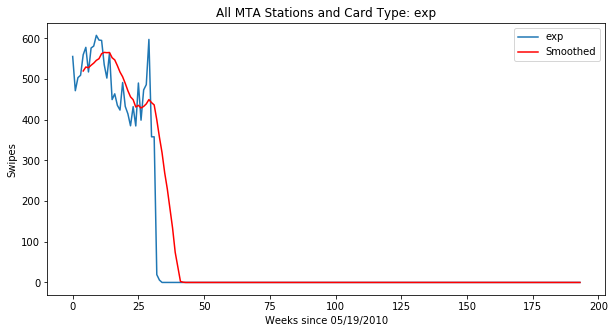

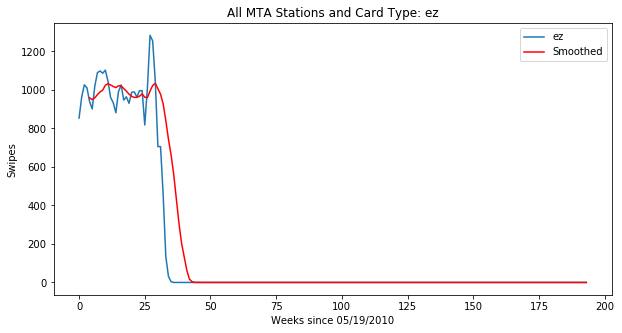

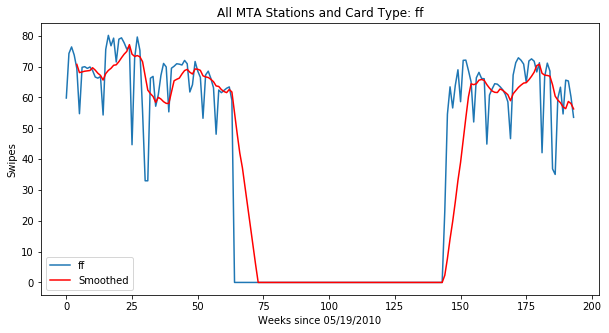

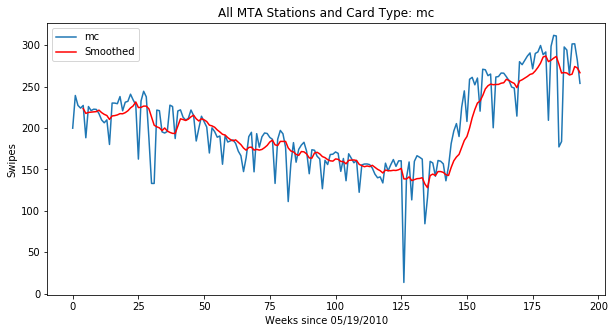

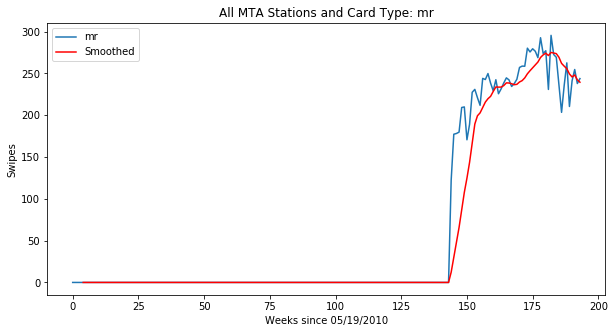

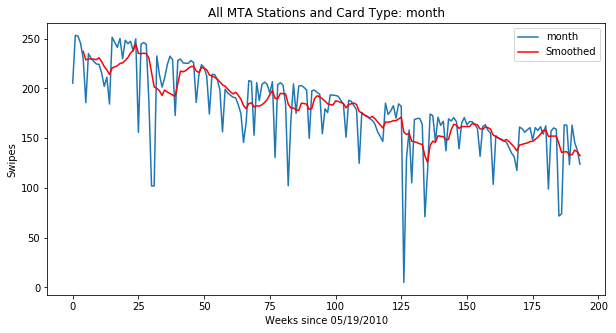

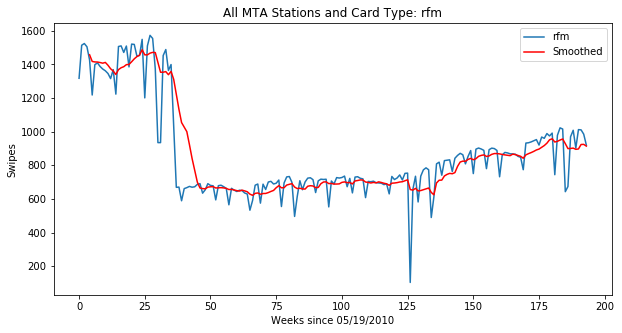

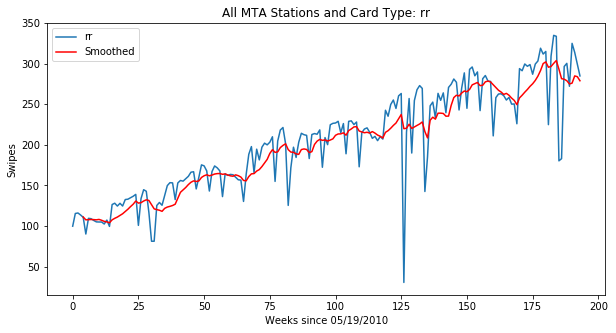

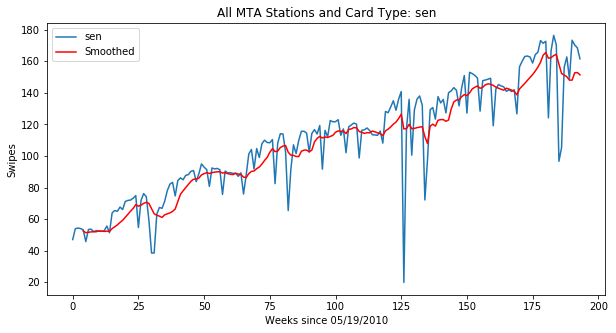

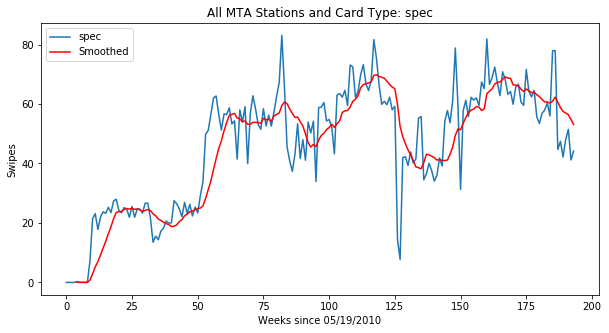

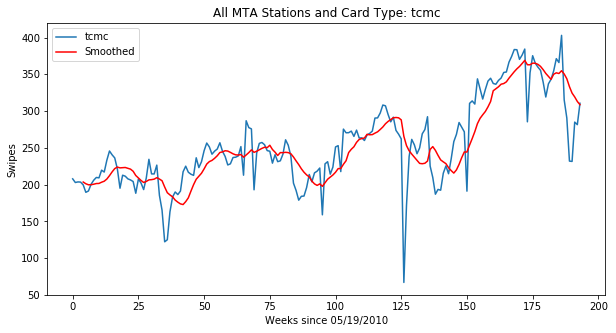

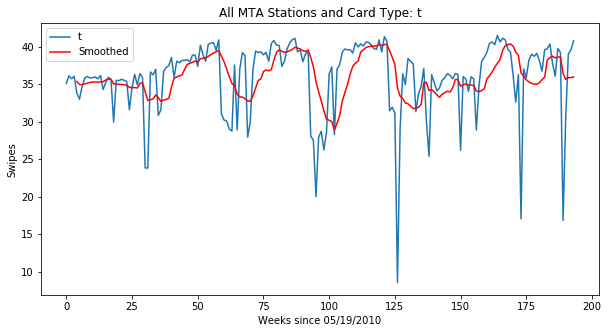

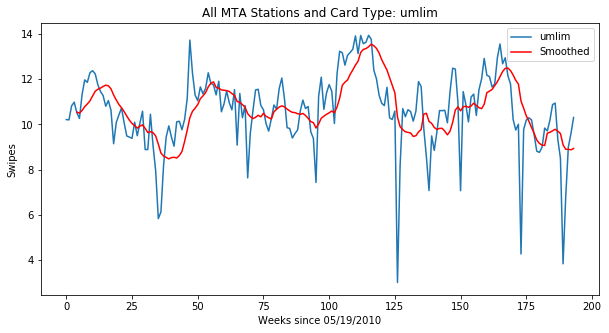

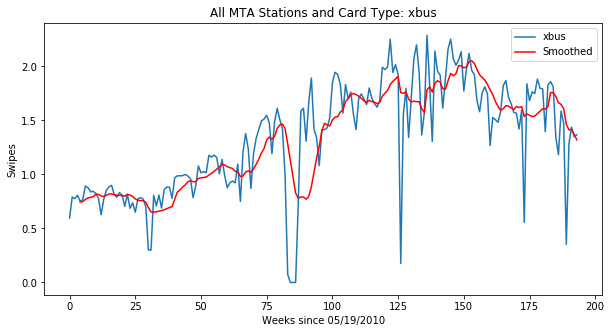

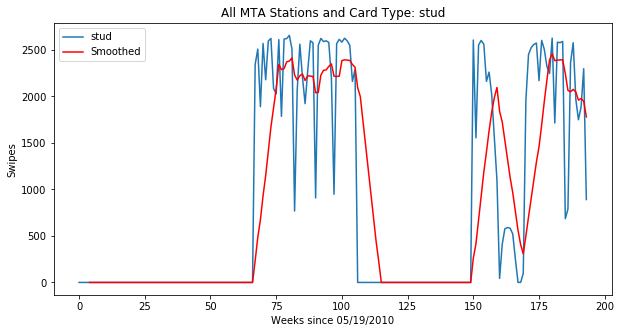

In [31]:
for i in ridetype:
    plt.figure(figsize=(10,5))
    plt.plot(mta_ridetype_df[i])
    plt.plot(mta_ridetype_df_rolling[i], color='red', label='Smoothed')
    plt.ylabel("Swipes")
    plt.xlabel("Weeks since 05/19/2010")
    plt.legend()
    plt.title('All MTA Stations and Card Type: '+ i)

Fig 5: Time series plot of card swipes over the date range for each of the 23 card types.  There are clear distinctions for each card type, in terms of number of swipes (some differ by order of magnitude). One interesting observation is card type 'mr' or Mail and Ride, didn't have any usage until after Week 127, when the major event occurred.

In [32]:
# Create list of ratios between sum of first 10 weeks and sum of last 10 weeks, for each card type

ratio = []
for i in range(0,22):
    ratio.append(sum(mta_ridetype[i][1:10])/sum(mta_ridetype[i][184:194]))

In [33]:
ratio

[0.88755909120142162,
 0.71923958146313605,
 0.81361250313317668,
 0.96609040237381771,
 0.87290147549746355,
 0.65193161132610133,
 1.0070706242742051,
 4336.9565217391309,
 84051.42857142858,
 608906.11111111112,
 1.1150250447015357,
 0.74913450814883775,
 3.756453796313945e-05,
 1.5729738913745259,
 1.3952839375080135,
 0.34990740486133443,
 0.31263284954988096,
 0.014248590833197336,
 0.58529400965056655,
 0.88130984421395919,
 1.1216914439200911,
 0.55634158665992928]

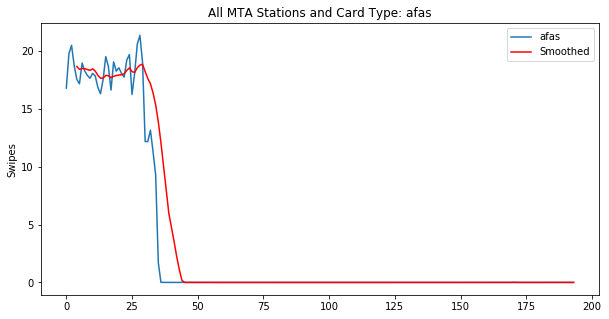

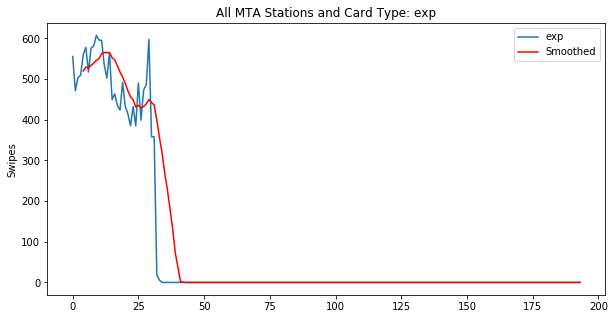

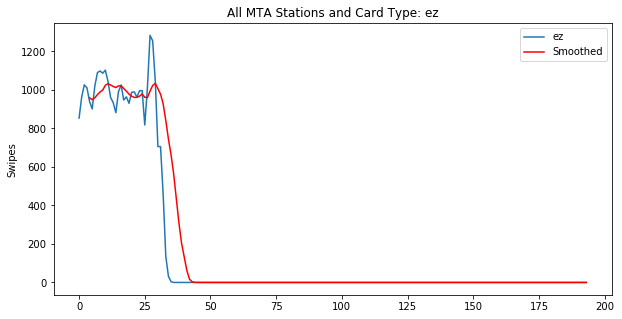

In [34]:
# Find steepest change among card types

for i in ridetype[7:10]:
    plt.figure(figsize=(10,5))
    plt.plot(mta_ridetype_df[i])
    plt.plot(mta_ridetype_df_rolling[i], color='red', label='Smoothed')
    plt.ylabel("Swipes")
    plt.legend()
    plt.title('All MTA Stations and Card Type: '+ i)

In [35]:
stations_time = np.nansum(mta_fare, axis=1)
stations_time.shape

(600, 194)

In [36]:
stations_mean = np.nanmean(stations_time, axis=1)
stations_mean.shape

(600,)

In [37]:
stations_std = np.nanstd(stations_time, axis=1)
stations_std.shape

(600,)

In [38]:
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationidclean = stationid[mta_fare.reshape(600*23, 194).std(axis=1) > 0]
stationidclean.shape

(8942,)

In [39]:
rtypeid = np.concatenate(np.repeat([np.array(range(23))], 600, axis=0))
rtypeidclean = rtypeid[mta_fare.reshape(600*23, 194).std(axis=1) > 0]
rtypeidclean.shape

(8942,)

In [40]:
tots = []

for i in range(0,len(rtypeidclean)):
    tots.append(mta_fare[stationidclean[i]][rtypeidclean[i]])

In [41]:
tots = np.asarray(tots)
tots.shape

(8942, 194)

In [42]:
normed_time_series = []

for i in range(len(rtypeidclean)):
    normed_time_series.append((tots[i] - tots[i].mean())/tots[i].std())

normed_time_series = np.asarray(normed_time_series)
normed_time_series.shape

(8942, 194)

In [43]:
normed_time_series_mean = normed_time_series.mean(axis=1)
normed_time_series_std = normed_time_series.std(axis=1)

In [44]:
tsmean = np.nanmean(tots, axis=1)
tsmean.shape

(8942,)

In [45]:
tsstdev = np.nanstd(tots, axis=1)
tsstdev.shape

(8942,)

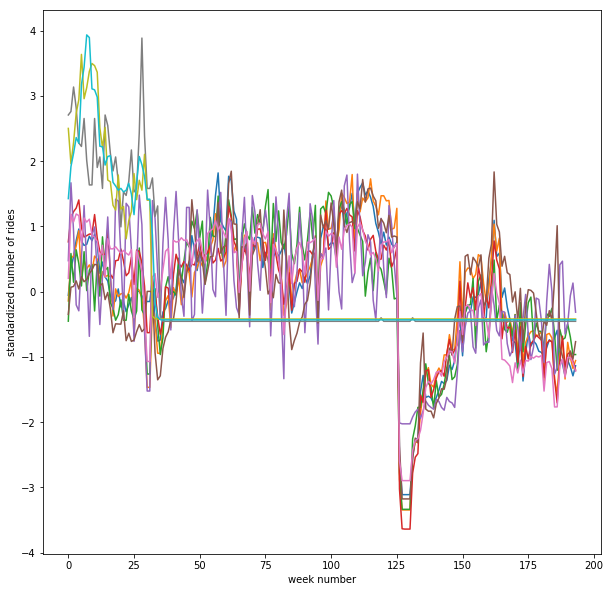

In [46]:
standardizedts = normed_time_series

pl.figure(figsize=(10,10))

for i in range(10):
    pl.plot(standardizedts[i])
    pl.xlabel("week number")
    pl.ylabel("standardized number of rides");